<a href="https://colab.research.google.com/github/harshpsi9194/Deep-learning/blob/main/Decision_tree_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classifiers from scratch

In this notebook, I have implemented the decision tree classifiers, on the famours Iris data set. The complete algorithm has been implemented from scratch, and only the basic python libraries of Numpy and Pandas is used

In [8]:
import numpy as np #importing the respective libraries
import pandas as pd


In [2]:
from sklearn import datasets #importing the dataset
iris = datasets.load_iris()

In [9]:
col_names = ['sepal_length', 'sepal_widht', 'petal_length', 'petal_width', 'type']
data = pd.DataFrame(data=iris.data, columns=col_names[:-1])
data['type'] = iris.target
data['type_name'] = iris.target_names[iris.target]
print(data.head(10))
print(data.info())
print(data.describe())       # Statistical summary
print(data['type_name'].value_counts())  # for getting the names of flowers

   sepal_length  sepal_widht  petal_length  petal_width  type type_name
0           5.1          3.5           1.4          0.2     0    setosa
1           4.9          3.0           1.4          0.2     0    setosa
2           4.7          3.2           1.3          0.2     0    setosa
3           4.6          3.1           1.5          0.2     0    setosa
4           5.0          3.6           1.4          0.2     0    setosa
5           5.4          3.9           1.7          0.4     0    setosa
6           4.6          3.4           1.4          0.3     0    setosa
7           5.0          3.4           1.5          0.2     0    setosa
8           4.4          2.9           1.4          0.2     0    setosa
9           4.9          3.1           1.5          0.1     0    setosa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length 

As in any other from scratch implementation of machine learning model, here as well, we will be creating classes for our use sake.   
Specifically the following two classes would be required:   
1)Node    
2)Tree

In [10]:
#code for the node class
class Node():
  #constructor function
  def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
    #as the node can be of two types, decision and the leaf nodes, and thus will have different features
    #the leaf node requires nothing but the value, ie the majority class of the leaf node, that we will use to classify
    #a new data point
    #for a decision node, we will need the decision index(X0, X1 etc), the threashold value for the specific index. The left and the right can be thought of as
    #the left and the right node, and the info gain would be for that specific node

    #Leaf node
    self.value = value

    #Decision node
    self.feature_index = feature_index
    self.threshold = threshold
    self.left = left
    self.right = right
    self.info_gain = info_gain

In [53]:
#code for Tree class
class Tree():
  #defining the constructor function.
  def __init__(self, sample_split=4, max_depth=4):
    #just making the root fo the tree
    self.root = None
    #further, the following are the stopping conditions that will be used
    self.sample_split = sample_split
    self.max_depth = max_depth

  #Now we would be defining the mainly required function to run the decision tree algorithm.
  #This mainly contains the function to build a binary tree recurssively, whenever called upon. The other would be doing
  #the classification for the given tree parameters and the third would be updating the parameters.

  def make_tree(self, dataset, curr_depth = 0):
    X, Y = dataset[:,:-1], dataset[:, -1] #what this line does is the following => for X =>chooses all rows and all columns, except the last column(the class label)
    #and for Y, chooses all rows, and the last column. thus X => would have rows = number of samples, and each row will have the features corresponding to that sample
    #and Y => is just a simple vector, containing the output fetures.

    # Reshape Y to be a 2D array with a single column for consistent handling
    Y = Y.reshape(-1, 1)


    nof_sample, nof_features = np.shape(X) #=> I believe that now this is justified.

    #Now we will be defining the required conditions for further spliting or stopping of spilliting.
    if nof_sample >= self.sample_split and curr_depth <= self.max_depth: #=>i dont believe there would be any bt in these two conditions.
      #if these conditions are satisfied, the code should find the best split for it, and then we can split the tree further.
      #best split would have the max info gain!!!.
      best_split = self.get_best_split(dataset, nof_sample, nof_features)

      # If best_split was not found (e.g., all samples are the same class),
      # best_split might be empty or info_gain might not exist or be > 0
      # We should check if best_split is not empty and has 'info_gain' key
      if best_split and "info_gain" in best_split and best_split["info_gain"] > 0 :
        left_babytree= self.make_tree(best_split["dataset_left"], curr_depth+1)
        right_babytree= self.make_tree(best_split["dataset_right"], curr_depth+1)

        return Node(best_split["feature_index"], best_split["threshold"], left_babytree, right_babytree, best_split["info_gain"])

    #calculating the leaf value
    # Pass the reshaped Y (which is now 2D) to cal_leaf_value
    leaf_value = self.cal_leaf_value(Y)
    return Node(value = leaf_value)

  def get_best_split(self, dataset, nof_sample, nof_features):
    best_split = {} #you can see why it is a dictionary, it has feature_index, threshold, left_babytree and the right one as the keys and corresponding to those there are values present
    max_info_gain = -float("inf")

    #Now, an important point to note is that, it wont be possible to traverse through all the real number values possible for a particular threshold,
    #rather, what we can do, is to traverse through all the feature values as the threshold, as that is doable and kindof intutively makes sense.
    #Thus looping over all the features=>
    for feature_index in range(nof_features):
      feature_values = dataset[:, feature_index]
      possible_threshold = np.unique(feature_values)

      #now as we have got all the possbile threshold values, we will loop over them.
      for threshold in possible_threshold:
        dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
        #just checking if the childs are not null values
        if len(dataset_left) > 0 and len(dataset_right)> 0:
          # Ensure y, left_y, right_y are passed correctly for impurity calculation
          y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
          #now computing the information gain.
          curr_info_gain = self.info_gain(y, left_y, right_y, "gini")
          if curr_info_gain > max_info_gain :
            #we would need to update the best_split then
            best_split["feature_index"] = feature_index
            best_split["threshold"] = threshold
            best_split["dataset_left"] = dataset_left
            best_split["dataset_right"] = dataset_right
            best_split["info_gain"] = curr_info_gain
            max_info_gain = curr_info_gain

    return best_split


#This function splits the dataset, after calculating which point lies in which domain/array
  def split(self, dataset, feature_index, threshold):
    dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
    dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])

    return dataset_left, dataset_right


#a simple function employed to calculate the information gain
  def info_gain(self, parent, l_child, r_child, mode= "entropy"):
     # Ensure lengths are non-zero before calculating weights
     len_parent = len(parent)
     if len_parent == 0:
         return 0 # Avoid division by zero

     weight_l = len(l_child)/len_parent
     weight_r = len(r_child)/len_parent

     if mode == "gini":
      gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
     else :
      gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))

     return gain


#for entropy calculations, and ofcourse, without this, we can calculate the info gain.
  def entropy(self, Y):
    # Handle empty input array
    if len(Y) == 0:
        return 0

    class_labels = np.unique(Y)
    entropy = 0
    for cls in class_labels:
      # Ensure the class exists in Y before calculating probability
      if len(Y) > 0:
        p_cls = len(Y[Y==cls])/len(Y)
        # Avoid log2(0)
        if p_cls > 0:
            entropy += -p_cls*np.log2(p_cls)

    return entropy

  def gini_index(self, Y):
    # Handle empty input array
    if len(Y) == 0:
        return 0

    class_labels = np.unique(Y)
    gini_index = 0
    for cls in class_labels:
      # Ensure the class exists in Y before calculating probability
      if len(Y) > 0:
        p_cls = len(Y[Y==cls])/len(Y)
        gini_index += p_cls*p_cls

    return 1-gini_index

  def cal_leaf_value(self, y):
    # Ensure y is not empty
    if len(y) == 0:
        # Return a default value or handle as an error, depending on expected behavior for empty leaf
        # For now, returning None or the first class if available is a possibility.
        # Let's return None for simplicity in this context, indicating an issue.
        return None
    y = list(y.flatten()) # Flatten y in case it's 2D (from the reshape in make_tree)
    return max(y, key=y.count)


  def print_tree(self, tree=None, indent=" "):

    if not tree:
      tree = self.root
    if tree and tree.value is not None: # Added check for tree existence
      print(tree.value)

    elif tree: # Added check for tree existence
      print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
      print("%sleft:" % (indent), end="")
      self.print_tree(tree.left, indent + indent)
      print("%sright:" % (indent), end="")
      self.print_tree(tree.right, indent + indent)

  def fit(self, X, Y):
        ''' function to train the tree '''
        # Ensure Y is 2D before concatenating
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.make_tree(dataset)

  def predict(self, X):

        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

  def make_prediction(self, x, tree):

    if tree.value!=None: return tree.value
    feature_val = x[tree.feature_index]
    if feature_val<=tree.threshold:
      return self.make_prediction(x, tree.left)
    else:
      return self.make_prediction(x, tree.right)

In [54]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [55]:
classifier = Tree(sample_split=2, max_depth=2)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_2 <= 1.9 ? 0.33741385372714494
 left:setosa
 right:X_4 <= 1.0 ? 0.4999198846338727
  left:versicolor
  right:virginica


In [56]:
Y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

1.0

As we can see, that there has to be something wrong as we are getting 100% accuracy on over iris dataset.    
Thus below we visualize the dataset, just to see if it is that easily seperable

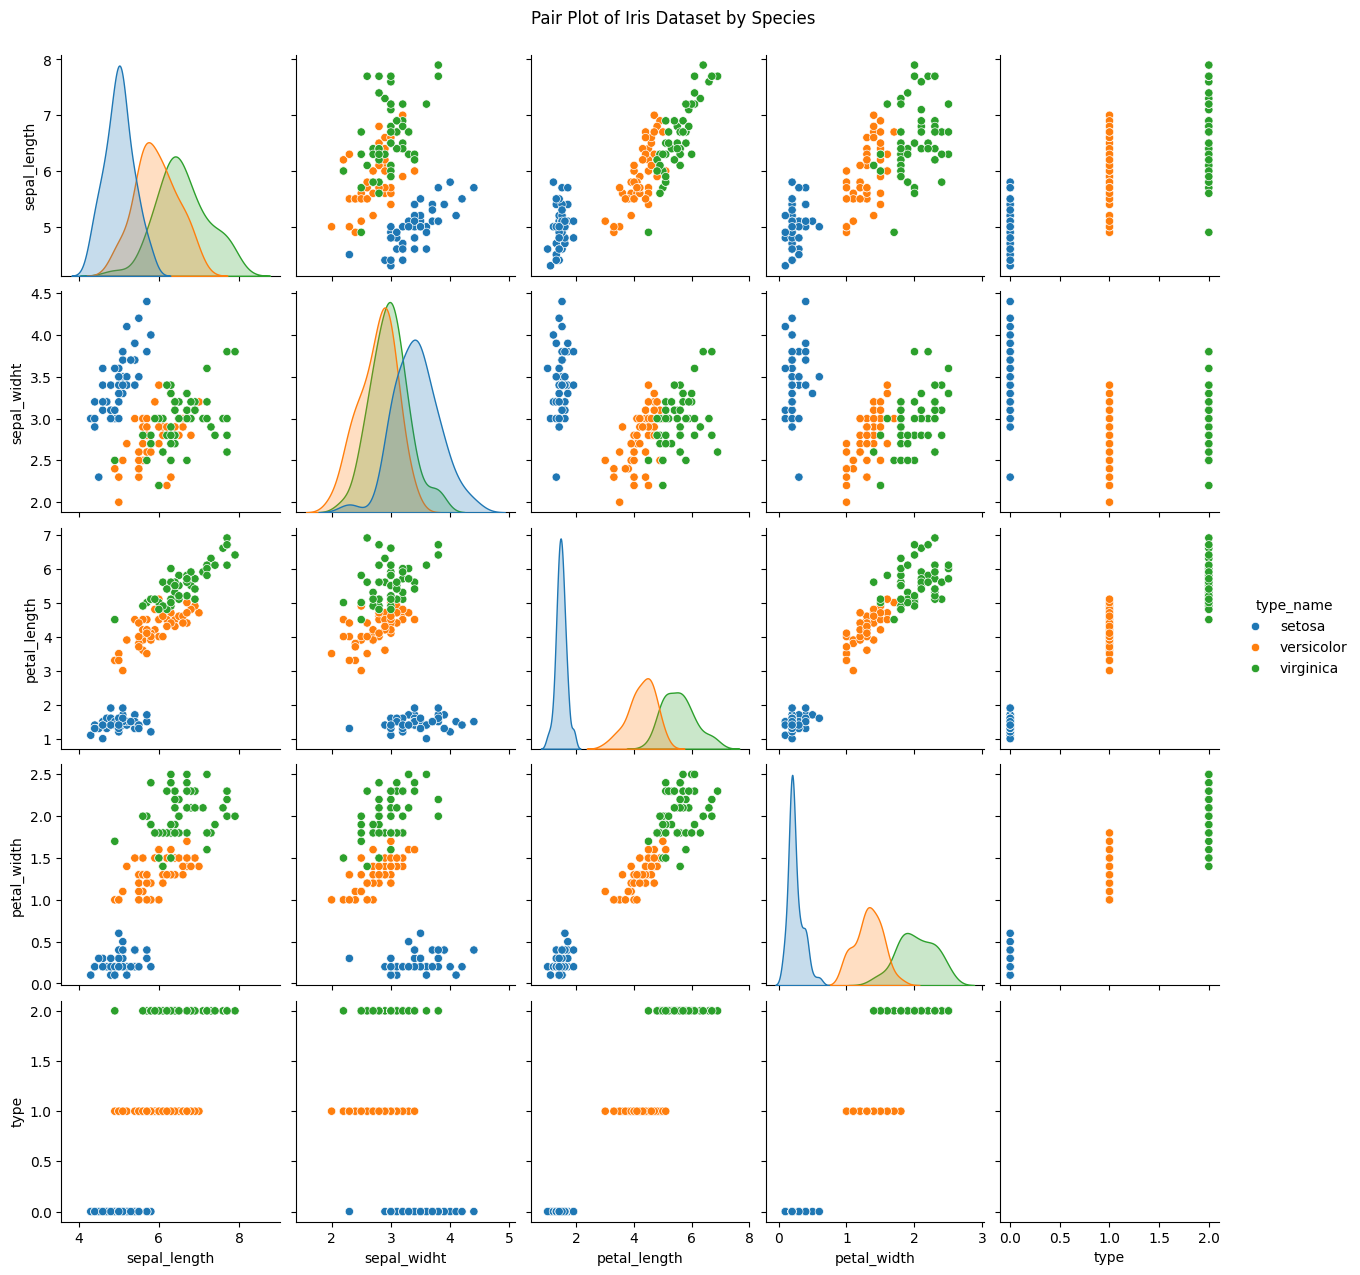

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pair plot of the dataset, colored by the 'type_name' column
sns.pairplot(data, hue='type_name')
plt.suptitle('Pair Plot of Iris Dataset by Species', y=1.02) # Add a title
plt.show()

Dont know exactly why it is happening man):
